# DEEP LEARNING - PRACTICUM 03

- Diego Roca Rodríguez
- Roi Santos Ríos

Wasserstein Generative Adversarial Networks, with Gradient Penalty (WGAN-GP)

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from numpy import iscomplexobj
from scipy.linalg import sqrtm

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, utils, metrics, optimizers
import tensorflow_hub as hub

import matplotlib.pyplot as plt

import glob

from utils import display, sample_batch, display_one, display_list

2023-05-12 12:37:27.360814: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 0. Parameters <a name="parameters"></a>

For the hyperparameter optimization, we've developed a script called WGAN_GP_script.py that performs a grid search by
training and evaluating the whole model with different hyperparameters. As this is a really time-consuming task, we've
decided to limit the search to the following hyperparameters and values:

- 

In [2]:
IMAGE_SIZE = 16
CHANNELS = 3

BATCH_SIZE = 64
NUM_FEATURES = 128
Z_DIM = 128


EPOCHS = 10
STEPS_PER_EPOCH = 1000


LEARNING_RATE = 0.0002
CRITIC_STEPS = 3

ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999

GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9

## 1. Prepare the data <a name="prepare"></a>

In [3]:
# Load the data
train_data = utils.image_dataset_from_directory(
    "./data/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

# Repeat the dataset
train_data = train_data.repeat()

Found 202599 files belonging to 1 classes.


2023-05-12 12:37:37.307700: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 12:37:37.308659: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
# Preprocess the data
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    
    return img


train = train_data.map(lambda x: preprocess(x))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


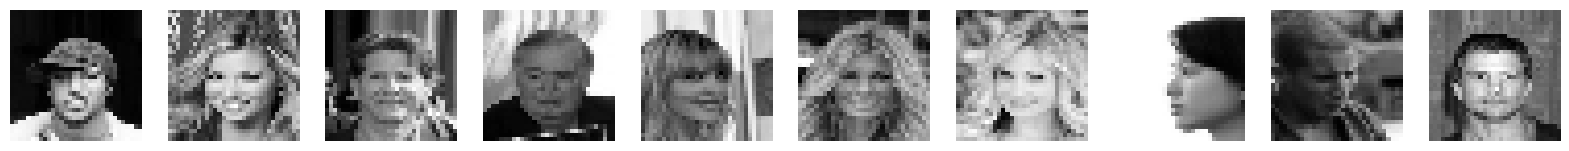

In [5]:
# Show some faces from the training set
train_sample = sample_batch(train)

display(train_sample, cmap="None")

In this line, we load the inception_v3 model that we will use later in order to calculate the FID.

In [6]:
# Load the pre-trained Inception v3 model
inception_v3 = hub.KerasLayer('https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5', input_shape=(299, 299, 3))

## 2. Build the WGAN-GP <a name="build"></a>

Regarding the modifications to the network, the ones proposed in class are the following:

- Adding more convolutional layers and increasing the model's depth
- Incorporating a residual connection
- Employing dilated convolutions

More convolutional layers and increasing the depth would make the model take much longer to train, even if it improves the results,
with our current hardware we cannot afford the time to train more complex models.
The residual connection would allow the network to be deeper and improve its training, but as already mentioned, increasing the depth
would make the model far too complex and time consuming to train for ud.
Lastly, dilated convolutions can expand the receptive field of the network without increasing the number of parameters, which is the
perfect solution for us, due to our hardware problems. This technique allows the network to capture larger contextual information,
so we implemented it by changing the Conv2D layers to the following:

Before:

``` x = Conv2D(64, kernel_size=2, strides=2, padding="same")(critic_input) ```

After:

``` x = Conv2D(64, kernel_size=2, strides=1, padding="same", dilation_rate=2)(critic_input) ```

It still requires considerably more time, thus we reduced the number of epochs to 5.

In [7]:
critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=2, strides=1, padding="same", dilation_rate=2)(critic_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=2, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, kernel_size=2, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=2, strides=1, padding="same")(x)
critic_output = layers.Flatten()(x)

critic = models.Model(critic_input, critic_output)

generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(256, kernel_size=2, strides=1, padding="valid", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(128, kernel_size=2, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(64, kernel_size=2, strides=1, padding="same", use_bias=False, dilation_rate=2)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(CHANNELS, kernel_size=2, strides=2, padding="same", activation="tanh")(x)

generator = models.Model(generator_input, generator_output)

critic.summary()
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         32896     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout (Dropout)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         131328

In [8]:
# critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
# x = layers.Conv2D(64, kernel_size=2, strides=2, padding="same")(critic_input)
# x = layers.LeakyReLU(0.2)(x)
# x = layers.Conv2D(128, kernel_size=2, strides=2, padding="same")(x)
# x = layers.LeakyReLU()(x)
# x = layers.Dropout(0.3)(x)
# x = layers.Conv2D(256, kernel_size=2, strides=2, padding="same")(x)
# x = layers.LeakyReLU(0.2)(x)
# x = layers.Dropout(0.3)(x)
# x = layers.Conv2D(1, kernel_size=2, strides=1, padding="same")(x)
# critic_output = layers.Flatten()(x)

# critic = models.Model(critic_input, critic_output)

# generator_input = layers.Input(shape=(Z_DIM,))
# x = layers.Reshape((1, 1, Z_DIM))(generator_input)
# x = layers.Conv2DTranspose(256, kernel_size=2, strides=1, padding="valid", use_bias=False)(x)
# x = layers.BatchNormalization(momentum=0.9)(x)
# x = layers.LeakyReLU(0.2)(x)
# x = layers.Conv2DTranspose(128, kernel_size=2, strides=2, padding="same", use_bias=False)(x)
# x = layers.BatchNormalization(momentum=0.9)(x)
# x = layers.LeakyReLU(0.2)(x)
# x = layers.Conv2DTranspose(64, kernel_size=2, strides=2, padding="same", use_bias=False)(x)
# x = layers.BatchNormalization(momentum=0.9)(x)
# x = layers.LeakyReLU(0.2)(x)
# generator_output = layers.Conv2DTranspose(CHANNELS, kernel_size=2, strides=2, padding="same", activation="tanh")(x)

# generator = models.Model(generator_input, generator_output)

# critic.summary()
# generator.summary()

In [9]:
class WGANGP(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.c_loss_metric, self.c_wass_loss_metric, self.c_gp_metric, self.g_loss_metric]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(real_predictions)
                c_gp = self.gradient_penalty(batch_size, real_images, fake_images)
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(zip(c_gradient, self.critic.trainable_variables))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

      # Calculate Critic and Generator Accuracy
        c_acc = tf.reduce_mean(tf.cast(tf.math.greater(real_predictions, 0), tf.float32)) * 100
        g_acc = tf.reduce_mean(tf.cast(tf.math.less(fake_predictions, 0), tf.float32)) * 100

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        #return {m.name: m.result() for m in self.metrics,'c_acc': c_acc,'g_acc': g_acc}    
        return {**{m.name: m.result() for m in self.metrics}, 'c_acc': c_acc, 'g_acc': g_acc}
    

In [10]:
# Create a GAN
wgangp = WGANGP(critic=critic, generator=generator, latent_dim=Z_DIM, critic_steps=CRITIC_STEPS, gp_weight=GP_WEIGHT)

In [11]:
if LOAD_MODEL:
    wgangp.load_weights("./checkpoint/checkpoint.ckpt")

## 3. Train the GAN <a name="train"></a>

In [12]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
    g_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
)

In [13]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(generated_images, save_to="./output/generated_img_%03d.png" % (epoch), cmap=None)

In [14]:
class LossHistory(callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.history = {
            'c_loss': [],
            'g_loss': [],
            'c_acc': [],
            'g_acc': [],
        }

    def on_epoch_end(self, epoch, logs=None):
        self.history['c_loss'].append(logs['c_loss'])
        self.history['g_loss'].append(logs['g_loss'])
        self.history['c_acc'].append(logs['c_acc'])
        self.history['g_acc'].append(logs['g_acc'])

loss_history = LossHistory()

To be able to see the evolution of the FID throughout the training process, we've decided to implement a new callback class.
This class, at the end of each training epoch, performs the following:

- Calls the WGAN's generator to create 10 images using randomized feature vectors.
- Preprocesses the generated images for the inception model, and then evaluates them.
- Loads 10 random real images from the dataset.
- Preprocesses the real images for the inception model, and then evaluates them.
- Calculates the FID using the (real and generated) features that the inception model outputs.

It also displays the real and generated images onscreen, as to be able to visually compare the model's performance.

In [15]:
class CalculateFid(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    # Define a function to calculate FID
    def calculate_fid(self, real_features, generated_features):
        # Calculate the mean and covariance of the real and generated features
        mu_real = np.mean(real_features, axis=0)
        mu_generated = np.mean(generated_features, axis=0)
        cov_real = np.cov(real_features, rowvar=False)
        cov_generated = np.cov(generated_features, rowvar=False)

        # Calculate the squared difference between the means
        diff = mu_real - mu_generated
        diff_squared = np.dot(diff, diff)

        # Calculate the square root of the product of the covariances
        cov_sqrt = sqrtm(cov_real.dot(cov_generated))
        
        if iscomplexobj(cov_sqrt):
            cov_sqrt = cov_sqrt.real

        # Calculate the FID
        fid = diff_squared + np.trace(cov_real + cov_generated - 2 * cov_sqrt)

        return fid

    def preprocess_inception(self, image):
        image = tf.image.resize(image, (299, 299))
        image = tf.keras.applications.inception_v3.preprocess_input(image)
        return image
    
    def on_epoch_end(self, epoch, logs=None):
        z_sample = np.random.normal(size=(self.num_img, Z_DIM))

        # Generate a batch of images using the model
        generated_images = wgangp.generator.predict(z_sample)

        # Preprocess the images
        prepd_gen_images = np.array([self.preprocess_inception(image) for image in generated_images])

        # Extract features from the images
        generated_features = inception_v3(prepd_gen_images)
        generated_features = tf.keras.backend.eval(generated_features)

        print("GENERATED IMAGES, EPOCH: ", epoch)
        display(generated_images, cmap="None")
        
        #Load 10 images at random
        real_images = np.array([tf.keras.preprocessing.image.img_to_array(
            tf.keras.preprocessing.image.load_img(image_path, target_size=(32, 32)))
                                for image_path in np.random.choice(
                                    glob.glob("./data/img_align_celeba/*.jpg"), self.num_img)])
        
        # Preprocess the images
        prepd_real_images = np.array([self.preprocess_inception(image) for image in real_images])

        # Extract features from the images
        real_features = inception_v3(prepd_real_images)
        real_features = tf.keras.backend.eval(real_features)

        #print(real_features.shape)
        print("REAL IMAGES, EPOCH: ", epoch)
        display_list(real_images, cmap="None")
        
        # Calculate the FID
        fid = self.calculate_fid(real_features, generated_features)
        print("-------------------------")
        print("EPOCH: ", epoch, " FID: ", fid)
        
calculate_fid = CalculateFid(num_img=10, latent_dim=Z_DIM)

In [16]:
loss_history = LossHistory()

wgangp.fit(
    train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[model_checkpoint_callback, tensorboard_callback, calculate_fid, loss_history],
)

Epoch 1/10


ValueError: in user code:

    File "/home/roi.santos.rios/roi.santos.rios/.conda/envs/dl/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/roi.santos.rios/roi.santos.rios/.conda/envs/dl/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/roi.santos.rios/roi.santos.rios/.conda/envs/dl/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/tmp/ipykernel_157499/3571536291.py", line 45, in train_step
        fake_predictions = self.critic(fake_images, training=True)
    File "/home/roi.santos.rios/roi.santos.rios/.conda/envs/dl/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/roi.santos.rios/roi.santos.rios/.conda/envs/dl/lib/python3.10/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 32, 32, 1), found shape=(None, 16, 16, 1)


In [ ]:
# Save the final models
generator.save("./models/generator")
critic.save("./models/critic")

INFO:tensorflow:Assets written to: ./models/generator/assets


INFO:tensorflow:Assets written to: ./models/generator/assets


INFO:tensorflow:Assets written to: ./models/critic/assets


INFO:tensorflow:Assets written to: ./models/critic/assets


# 4. Results

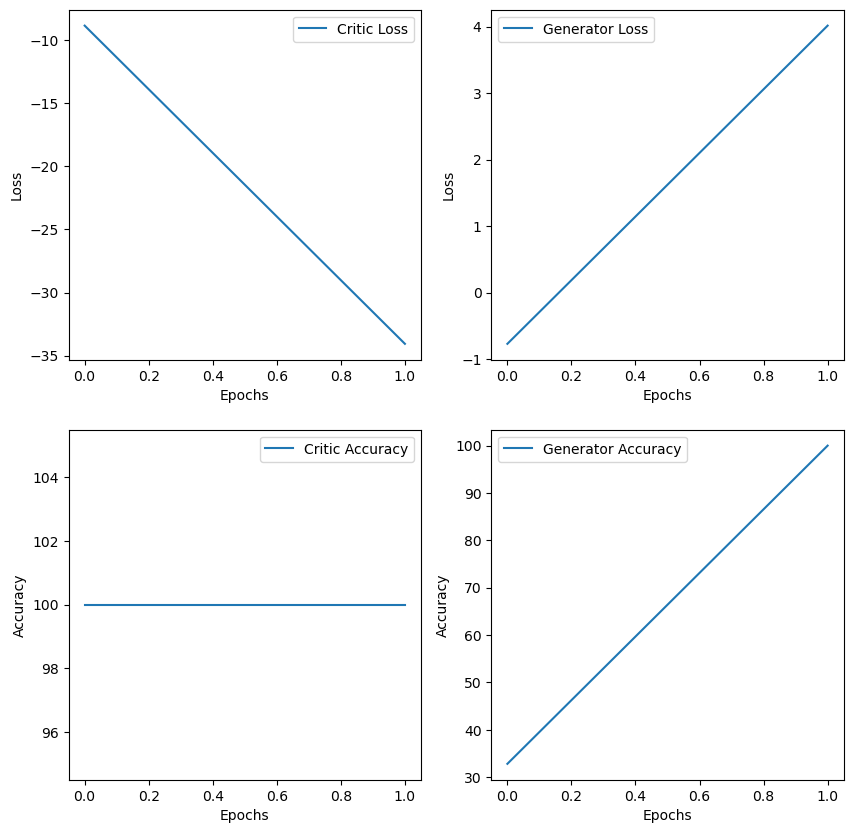

In [ ]:
def plot_losses_and_accuracy(loss_history):
    epochs = len(loss_history.history['c_loss'])
    x = range(epochs)

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    
    axs[0, 0].plot(x, loss_history.history['c_loss'], label="Critic Loss")
    axs[0, 0].set(xlabel="Epochs", ylabel="Loss")
    axs[0, 0].legend()
    
    axs[0, 1].plot(x, loss_history.history['g_loss'], label="Generator Loss")
    axs[0, 1].set(xlabel="Epochs", ylabel="Loss")
    axs[0, 1].legend()
    
    axs[1, 0].plot(x, loss_history.history['c_acc'], label="Critic Accuracy")
    axs[1, 0].set(xlabel="Epochs", ylabel="Accuracy")
    axs[1, 0].legend()
    
    axs[1, 1].plot(x, loss_history.history['g_acc'], label="Generator Accuracy")
    axs[1, 1].set(xlabel="Epochs", ylabel="Accuracy")
    axs[1, 1].legend()

    plt.show()

plot_losses_and_accuracy(loss_history)